### Import Library

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch, torchvision
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Segmentation Model
from Model.Segmentation.ResNetUNet import ResNetUNet

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

torch.multiprocessing.set_start_method('spawn')

### Load Segmentation Model

In [2]:
seg_device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
seg_model = ResNetUNet(n_class = 1).to(seg_device)
seg_model.load_state_dict(torch.load('./PreTrainModel/seg_model.pt'))

# No Train Segmentation Model
for p in seg_model.parameters():
    p.requires_grad = False

In [3]:
seg_model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### EDA

In [4]:
# Image Path
train_image_path = glob('./Dataset/Train/*.jpg')
train_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in train_image_path}

val_image_path = glob('./Dataset/Val/*.jpg')
val_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in val_image_path}

test_image_path = glob('./Dataset/Test/*.jpg')
test_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in test_image_path}

all_image_path = dict(train_path_dict, **val_path_dict, **test_path_dict)

# For Label
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

def define_split(x):
    if 'Train' in x:
        return 'Train'
    elif 'Val' in x:
        return 'Val'
    else:
        return 'Test'

# MetaData
df_original = pd.read_csv(os.path.join('./Dataset', 'Metadata.csv'))
df_original['path'] = df_original['image_id'].map(all_image_path.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original['split'] = df_original['path'].apply(lambda x:define_split(x))

# Split df -> Train, Val, Test
df_train = df_original[df_original['split'] == 'Train'].copy()
df_val = df_original[df_original['split'] == 'Val'].copy()
df_test = df_original[df_original['split'] == 'Test'].copy()

# Train Oversampling
data_aug_rate = [int(4018/202), int(4018/302),int(4018/686), int(4018/57), 0, int(4018/84), int(4018/660)]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
        
# Reset Index
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

### Make DataLoader

In [5]:
# Parameter => Equal to Segmentation_Model
input_size = 224
norm_mean = [0.76304215, 0.5456439, 0.5700431]
norm_std = [0.14092751, 0.15261441, 0.16997588]

# Transform
# Train Transform
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# Validation & Test Transform
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

In [6]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [7]:
train_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

**Visualization of Effect Segmentation $\alpha$ = 0.1**

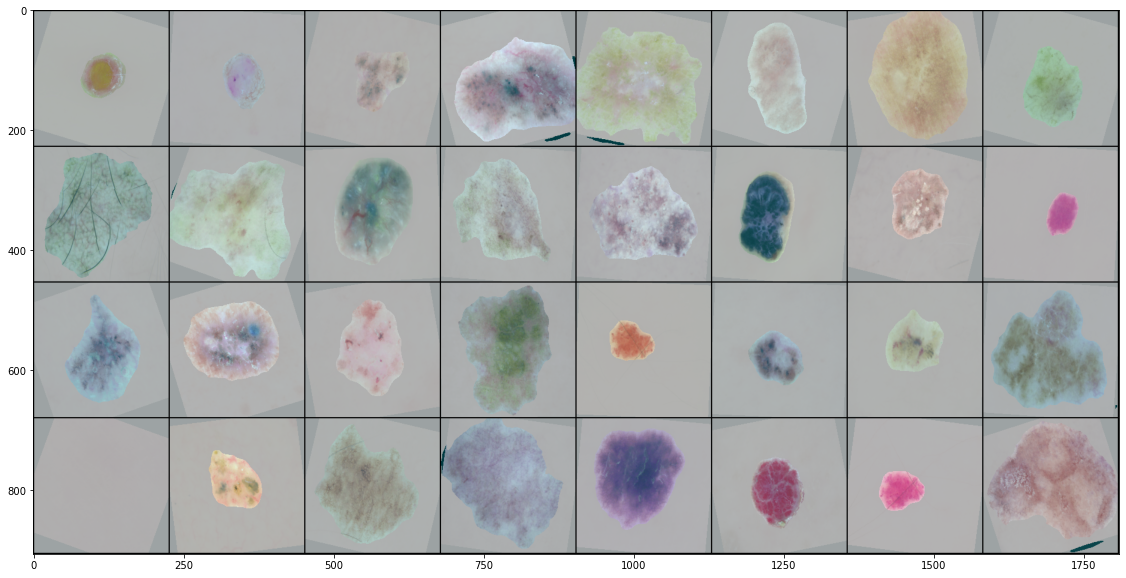

In [8]:
back_alpha = 0.1
dataiter = iter(train_loader)
img, seg = dataiter.next()

seg_img = seg_model(img.to(seg_device))
seg_img = torch.round(torch.sigmoid(seg_img))
seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
seg_img[seg_img == 0] = back_alpha
img = torch.mul(img, seg_img.cpu())

plt.figure(figsize=(20, 10))
plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))

**Visualization of Effect Segmentation $\alpha$ = 0.7**

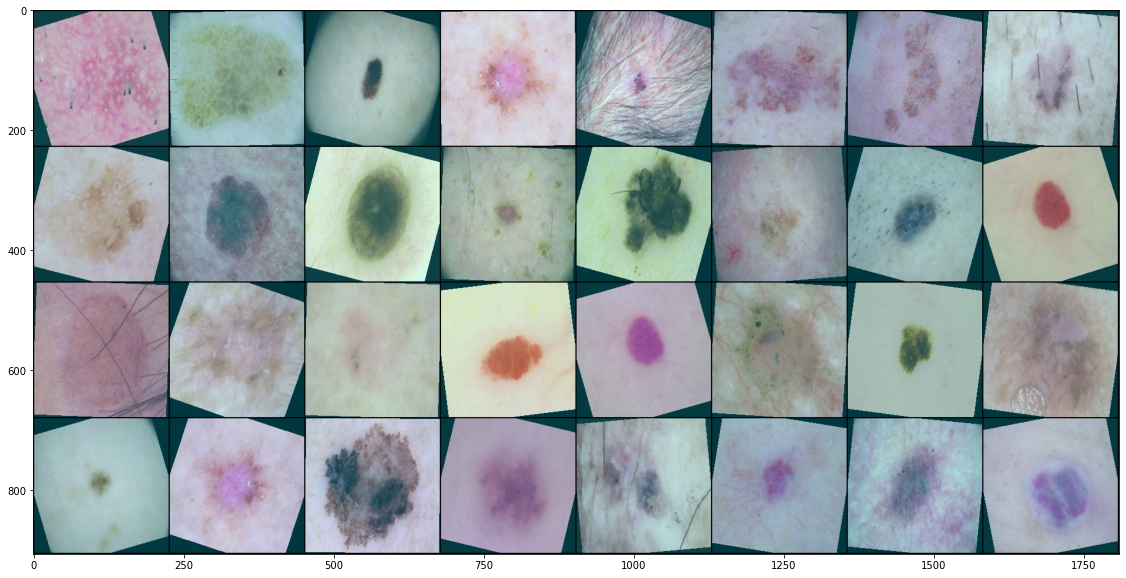

In [9]:
back_alpha = 1.0
dataiter = iter(train_loader)
img, seg = dataiter.next()

seg_img = seg_model(img.to(seg_device))
seg_img = torch.round(torch.sigmoid(seg_img))
seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
seg_img[seg_img == 0] = back_alpha
img = torch.mul(img, seg_img.cpu())

plt.figure(figsize=(20, 10))
plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))

### Train Model

**Metric**

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**Train**

In [11]:
def train(train_loader, model, criterion, optimizer, epoch, device, seg_model, seg_device, back_alpha):
    total_loss_train, total_acc_train = [],[]
    
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        
        # Segmentation
        seg_img = seg_model(images.to(seg_device))
        seg_img = torch.round(torch.sigmoid(seg_img))
        seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
        seg_img[seg_img == 0] = back_alpha
        images = torch.mul(images, seg_img.cpu())
        
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

**Validation**

In [12]:
def validate(val_loader, model, criterion, optimizer, epoch, device, seg_model, seg_device, back_alpha):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            # Segmentation
            seg_img = seg_model(images.to(seg_device))
            seg_img = torch.round(torch.sigmoid(seg_img))
            seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
            seg_img[seg_img == 0] = back_alpha
            images = torch.mul(images, seg_img.cpu())
        
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

**Model Train & Save Best Model**

In [13]:
def train_validation(back_alpha, df, transform, seg_model, seg_device):
    save_path = './PreTrainModel/'+str(round(back_alpha,2))+'_clf_model.pt'
    device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    best_val_acc = 0
    
    df_train, df_val = df
    train_transform, val_transform = transform

    # DenseNet -> Output:7
    model_ft = models.densenet121(pretrained=True)
    # set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, 7)
    model = model_ft.to(device)
    
    # Optimizer & LossFunction
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss().to(device)
    
    epoch_num = 10
    
    # DataLoader
    # Train
    training_set = HAM10000(df_train, train_transform)
    train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=0)

    # Val
    val_set = HAM10000(df_val, val_transform)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)
    
    total_loss_val, total_acc_val = [],[]

    for epoch in range(1, epoch_num+1):
        loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch, device, seg_model, seg_device, back_alpha)
        loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch, device, seg_model, seg_device, back_alpha)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
            torch.save(model.state_dict(), save_path)

In [14]:
for back_alpha in tqdm(np.arange(0.1, 1.0, 0.1), desc='Alpha...'):
    train_validation(back_alpha, [df_train, df_val], [train_transform, val_transform], seg_model, seg_device)

Alpha...:   0%|          | 0/9 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 848], [train loss 1.25988], [train acc 0.53906]
[epoch 1], [iter 200 / 848], [train loss 1.15063], [train acc 0.57703]
[epoch 1], [iter 300 / 848], [train loss 1.07179], [train acc 0.60594]
[epoch 1], [iter 400 / 848], [train loss 1.02688], [train acc 0.62367]
[epoch 1], [iter 500 / 848], [train loss 0.98578], [train acc 0.63794]
[epoch 1], [iter 600 / 848], [train loss 0.94129], [train acc 0.65385]
[epoch 1], [iter 700 / 848], [train loss 0.91089], [train acc 0.66308]
[epoch 1], [iter 800 / 848], [train loss 0.88568], [train acc 0.67156]
------------------------------------------------------------
[epoch 1], [val loss 1.31032], [val acc 0.58887]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.31032], [val acc 0.58887]
*****************************************************
[epoch 2], [iter 100 / 848], [train loss 0.64407], [train acc 0.76187]
[epoch 2], [iter 200

Alpha...:  11%|█         | 1/9 [2:13:28<17:47:51, 8008.88s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.69922], [val acc 0.77788]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.26009], [train acc 0.53812]
[epoch 1], [iter 200 / 848], [train loss 1.12797], [train acc 0.58516]
[epoch 1], [iter 300 / 848], [train loss 1.03632], [train acc 0.61990]
[epoch 1], [iter 400 / 848], [train loss 0.98379], [train acc 0.63867]
[epoch 1], [iter 500 / 848], [train loss 0.93425], [train acc 0.65694]
[epoch 1], [iter 600 / 848], [train loss 0.90128], [train acc 0.66823]
[epoch 1], [iter 700 / 848], [train loss 0.87417], [train acc 0.67812]
[epoch 1], [iter 800 / 848], [train loss 0.85375], [train acc 0.68559]
------------------------------------------------------------
[epoch 1], [val loss 0.94443], [val acc 0.61670]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

[epoch 10], [iter 600 / 848], [train loss 0.20334], [train acc 0.92380]
[epoch 10], [iter 700 / 848], [train loss 0.20430], [train acc 0.92272]
[epoch 10], [iter 800 / 848], [train loss 0.20202], [train acc 0.92414]


Alpha...:  22%|██▏       | 2/9 [4:30:35<15:49:18, 8136.95s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.68591], [val acc 0.79381]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.24986], [train acc 0.54125]
[epoch 1], [iter 200 / 848], [train loss 1.12425], [train acc 0.58969]
[epoch 1], [iter 300 / 848], [train loss 1.04457], [train acc 0.61823]
[epoch 1], [iter 400 / 848], [train loss 0.99015], [train acc 0.63773]
[epoch 1], [iter 500 / 848], [train loss 0.94568], [train acc 0.65150]
[epoch 1], [iter 600 / 848], [train loss 0.91120], [train acc 0.66359]
[epoch 1], [iter 700 / 848], [train loss 0.87947], [train acc 0.67460]
[epoch 1], [iter 800 / 848], [train loss 0.86348], [train acc 0.67984]
------------------------------------------------------------
[epoch 1], [val loss 0.91370], [val acc 0.69209]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

Alpha...:  33%|███▎      | 3/9 [6:48:45<13:40:39, 8206.63s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.72538], [val acc 0.75360]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.23163], [train acc 0.53875]
[epoch 1], [iter 200 / 848], [train loss 1.08841], [train acc 0.59297]
[epoch 1], [iter 300 / 848], [train loss 1.00858], [train acc 0.62708]
[epoch 1], [iter 400 / 848], [train loss 0.95268], [train acc 0.64734]
[epoch 1], [iter 500 / 848], [train loss 0.90958], [train acc 0.66281]
[epoch 1], [iter 600 / 848], [train loss 0.87376], [train acc 0.67490]
[epoch 1], [iter 700 / 848], [train loss 0.85002], [train acc 0.68308]
[epoch 1], [iter 800 / 848], [train loss 0.82346], [train acc 0.69250]
------------------------------------------------------------
[epoch 1], [val loss 0.79126], [val acc 0.68875]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

Alpha...:  44%|████▍     | 4/9 [9:05:21<11:23:32, 8202.60s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.72549], [val acc 0.76467]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.28617], [train acc 0.52531]
[epoch 1], [iter 200 / 848], [train loss 1.11802], [train acc 0.58781]
[epoch 1], [iter 300 / 848], [train loss 1.05078], [train acc 0.61313]
[epoch 1], [iter 400 / 848], [train loss 0.98892], [train acc 0.63562]
[epoch 1], [iter 500 / 848], [train loss 0.94250], [train acc 0.64994]
[epoch 1], [iter 600 / 848], [train loss 0.90151], [train acc 0.66578]
[epoch 1], [iter 700 / 848], [train loss 0.87136], [train acc 0.67616]
[epoch 1], [iter 800 / 848], [train loss 0.84541], [train acc 0.68586]
------------------------------------------------------------
[epoch 1], [val loss 0.83094], [val acc 0.63521]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

Alpha...:  56%|█████▌    | 5/9 [11:19:40<9:03:22, 8150.70s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.65889], [val acc 0.80571]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.21462], [train acc 0.54969]
[epoch 1], [iter 200 / 848], [train loss 1.09669], [train acc 0.59328]
[epoch 1], [iter 300 / 848], [train loss 1.00952], [train acc 0.62615]
[epoch 1], [iter 400 / 848], [train loss 0.95740], [train acc 0.64547]
[epoch 1], [iter 500 / 848], [train loss 0.90698], [train acc 0.66394]
[epoch 1], [iter 600 / 848], [train loss 0.86599], [train acc 0.67990]
[epoch 1], [iter 700 / 848], [train loss 0.83787], [train acc 0.69174]
[epoch 1], [iter 800 / 848], [train loss 0.80958], [train acc 0.70223]
------------------------------------------------------------
[epoch 1], [val loss 1.04880], [val acc 0.62774]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1

[epoch 10], [iter 600 / 848], [train loss 0.18049], [train acc 0.93198]
[epoch 10], [iter 700 / 848], [train loss 0.18041], [train acc 0.93192]
[epoch 10], [iter 800 / 848], [train loss 0.18140], [train acc 0.93141]


Alpha...:  67%|██████▋   | 6/9 [13:34:58<6:46:58, 8139.56s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.77236], [val acc 0.76749]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.23514], [train acc 0.54000]
[epoch 1], [iter 200 / 848], [train loss 1.09256], [train acc 0.59703]
[epoch 1], [iter 300 / 848], [train loss 1.01435], [train acc 0.62854]
[epoch 1], [iter 400 / 848], [train loss 0.94932], [train acc 0.65086]
[epoch 1], [iter 500 / 848], [train loss 0.90962], [train acc 0.66481]
[epoch 1], [iter 600 / 848], [train loss 0.87495], [train acc 0.67703]
[epoch 1], [iter 700 / 848], [train loss 0.85272], [train acc 0.68536]
[epoch 1], [iter 800 / 848], [train loss 0.82381], [train acc 0.69602]
------------------------------------------------------------
[epoch 1], [val loss 0.91334], [val acc 0.66990]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

Alpha...:  78%|███████▊  | 7/9 [15:49:32<4:30:36, 8118.35s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.66788], [val acc 0.79610]
------------------------------------------------------------
[epoch 1], [iter 100 / 848], [train loss 1.19615], [train acc 0.56563]
[epoch 1], [iter 200 / 848], [train loss 1.06612], [train acc 0.61203]
[epoch 1], [iter 300 / 848], [train loss 0.99378], [train acc 0.63885]
[epoch 1], [iter 400 / 848], [train loss 0.94198], [train acc 0.65352]
[epoch 1], [iter 500 / 848], [train loss 0.89329], [train acc 0.67169]
[epoch 1], [iter 600 / 848], [train loss 0.86132], [train acc 0.68245]
[epoch 1], [iter 700 / 848], [train loss 0.82941], [train acc 0.69353]
[epoch 1], [iter 800 / 848], [train loss 0.80112], [train acc 0.70336]
------------------------------------------------------------
[epoch 1], [val loss 0.88355], [val acc 0.66943]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0

Alpha...:  89%|████████▉ | 8/9 [18:06:43<2:15:54, 8154.25s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.71796], [val acc 0.81529]
------------------------------------------------------------
*****************************************************
best record: [epoch 10], [val loss 0.71796], [val acc 0.81529]
*****************************************************
[epoch 1], [iter 100 / 848], [train loss 1.23816], [train acc 0.54250]
[epoch 1], [iter 200 / 848], [train loss 1.09494], [train acc 0.59813]
[epoch 1], [iter 300 / 848], [train loss 1.01844], [train acc 0.62469]
[epoch 1], [iter 400 / 848], [train loss 0.94940], [train acc 0.65078]
[epoch 1], [iter 500 / 848], [train loss 0.90585], [train acc 0.66587]
[epoch 1], [iter 600 / 848], [train loss 0.86582], [train acc 0.68005]
[epoch 1], [iter 700 / 848], [train loss 0.84222], [train acc 0.68710]
[epoch 1], [iter 800 / 848], [train loss 0.81233], [train acc 0.69941]
------------------------------------------------------------
[epoch 1], [val loss 0.96171

[epoch 10], [iter 100 / 848], [train loss 0.17283], [train acc 0.93531]
[epoch 10], [iter 200 / 848], [train loss 0.16711], [train acc 0.93641]
[epoch 10], [iter 300 / 848], [train loss 0.17608], [train acc 0.93312]
[epoch 10], [iter 400 / 848], [train loss 0.17622], [train acc 0.93375]
[epoch 10], [iter 500 / 848], [train loss 0.18029], [train acc 0.93256]
[epoch 10], [iter 600 / 848], [train loss 0.18253], [train acc 0.93188]
[epoch 10], [iter 700 / 848], [train loss 0.17755], [train acc 0.93402]
[epoch 10], [iter 800 / 848], [train loss 0.17516], [train acc 0.93480]


Alpha...: 100%|██████████| 9/9 [20:20:26<00:00, 8136.28s/it]  

------------------------------------------------------------
[epoch 10], [val loss 0.77301], [val acc 0.78652]
------------------------------------------------------------


### Model Test

In [15]:
def test(test_loader, seg_model, seg_device, back_alpha):
    model_path = './PreTrainModel/'+str(round(back_alpha,2))+'_clf_model.pt'
    device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    
    # DenseNet -> Output:7
    model_ft = models.densenet121(pretrained=True)
    # set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, 7)
    model = model_ft.to(device)
    # Load PreTrain Model
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    y_label = []
    y_predict = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            
            # Segmentation
            seg_img = seg_model(images.to(seg_device))
            seg_img = torch.round(torch.sigmoid(seg_img))
            seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
            seg_img[seg_img == 0] = back_alpha
            images = torch.mul(images, seg_img.cpu())
            
            images = Variable(images).to(device)
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
            
    # Generate a classification report
    plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
    
    report = classification_report(y_label, y_predict, target_names=plot_labels)
    print(report)

In [16]:
# Test
test_set = HAM10000(df_test, val_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0)

In [17]:
for back_alpha in np.arange(0.1, 1.0, 0.1):
    print('\n\nBack Alpha....: {}'.format(str(round(back_alpha,2))))
    test(test_loader, seg_model, seg_device, back_alpha)



Back Alpha....: 0.1
              precision    recall  f1-score   support

       akiec       0.37      0.69      0.48        61
         bcc       0.76      0.75      0.76       113
         bkl       0.50      0.63      0.56       213
          df       0.69      0.69      0.69        26
          nv       0.93      0.85      0.89      1340
        vasc       0.90      0.70      0.79        27
         mel       0.52      0.57      0.55       223

    accuracy                           0.78      2003
   macro avg       0.67      0.70      0.67      2003
weighted avg       0.81      0.78      0.79      2003



Back Alpha....: 0.2
              precision    recall  f1-score   support

       akiec       0.47      0.61      0.53        61
         bcc       0.69      0.78      0.73       113
         bkl       0.65      0.59      0.62       213
          df       0.78      0.69      0.73        26
          nv       0.92      0.88      0.90      1340
        vasc       0.80      0.89 